# Markov Chain Monte Carlo Example 1
Author: Michael D. Shields
Date: May 15, 2018
Last modified: March 18, 2019 by Audrey Olivier

In this example, the Metropolis-Hastings, component-wise modified Metropolis-Hastings, and affine invariant ensemble sampler with stretch moves are employed to generate samples from a Rosenbrock distribution. The method illustrates various aspects of the UQpy MCMC class. In these illustrations, the Rosenbrock pdf is defined directly in the script as a python function. For examples where the pdf is defined using a custom distribution and passed in as a string to the MCMC class, see MCMC_Example2.

Import the necessary libraries. Here we import standard libraries such as numpy and matplotlib, but also need to import the MCMC class from UQpy.

In [1]:
from UQpy.SampleMethods import MCMC
import numpy as np
import matplotlib.pyplot as plt
import time

Define the Rosenbrock probability density function up to a scale factor. Here the pdf is defined directly in the python script. In Example 2, the pdf will be defined externally through a custom distribution script. First, we use the 'MH' algorithm to demonstrate several ways to define the target pdf: <br>
- define the Rosenbrock probability density function up to a scale factor, this function only takes as input parameter the point x where to compute the pdf, <br>
- define a pdf function that also takes as argument a set of parameters params,
- define a function that computes the log pdf up to a constant.

In [2]:
def Rosenbrock_no_params(x):
     return np.exp(-(100*(x[1]-x[0]**2)**2+(1-x[0])**2)/20)
    
def Rosenbrock(x, params):
     return np.exp(-(100*(x[1]-x[0]**2)**2+(1-x[0])**2)/params[0])
    
def log_Rosenbrock(x):
     return (-(100*(x[1]-x[0]**2)**2+(1-x[0])**2)/20)

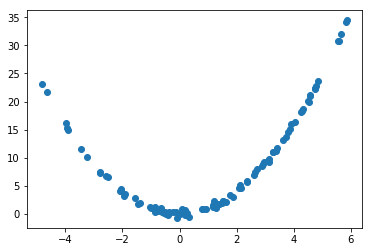

In [3]:
x = MCMC(dimension=2, pdf_proposal_type='Normal', pdf_proposal_scale=[1.,1.],
         pdf_target=Rosenbrock_no_params, pdf_target_params = None, algorithm='MH', jump=1000, nsamples=100, seed=None)
plt.plot(x.samples[:,0],x.samples[:,1],'o')
plt.show()

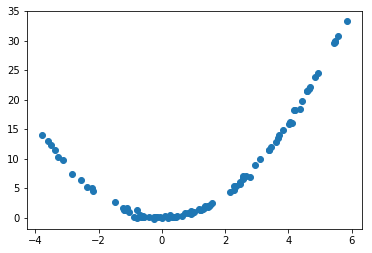

In [4]:
x = MCMC(dimension=2, pdf_proposal_type='Normal', pdf_proposal_scale=[1.,1.],
         pdf_target=Rosenbrock, pdf_target_params = [20], algorithm='MH', jump=1000, nsamples=100, seed=None)
plt.plot(x.samples[:,0],x.samples[:,1],'o')
plt.show()

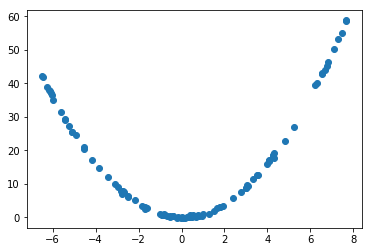

In [5]:
x = MCMC(dimension=2, pdf_proposal_type='Normal', pdf_proposal_scale=[1.,1.],
         log_pdf_target=log_Rosenbrock, pdf_target_params = None, algorithm='MH', jump=1000, nsamples=100, seed=None)
plt.plot(x.samples[:,0],x.samples[:,1],'o')
plt.show()

In the following the various algorithms supported by UQpy are compared.

Run MCMC using the defined Rosenbrock distribution for 100 samples using the component-wise modified Metropolis-Hastings Algorithm. Here we use the following parameters.
    - Normal proposal pdf with unit variance.
    - Samples are accepted/rejected based on the ratio of the joint pdf. This is necessary as the dependence of the Rosenbrock pdf does not allow us to accept/reject based on independent marginals.
    - Notice that pdf_target references the Rosenbrock function directly and does not designate it as a string.
    - A jumping with of 1000 samples. 
    - Seed value is set to the default.
    - No burn (nburn) is specified.
These samples serve as the seed values for MCMC using the affine invariant ensemble sampler with stretch moves.

In [6]:
x = MCMC(dimension=2, pdf_proposal_type='Normal', pdf_proposal_scale=[1.,1.], pdf_target_type='joint_pdf',
         pdf_target=Rosenbrock, pdf_target_params = [20], algorithm='MMH', jump=1000, nsamples=100, seed=None)

Run MCMC using the defined Rosenbrock distribution to generate 1000 samples using the affine invariant ensemble sampler with stretch moves. Note the following:
    - The scale parameter for the stretch moves is set to 2. This is standard from the literature. (Goodman and Weare, 2010). 
    - x.samples, the 100 samples generated above, are used as the seed for the stretch algorithm. This means we propagate an ensemble of size 100.

In [7]:
for _ in range(10):
    t = time.time()
    z = MCMC(dimension=2, pdf_proposal_type=None, pdf_proposal_scale=2,
             log_pdf_target=log_Rosenbrock, algorithm='Stretch', jump=1000, nsamples=1000, seed=x.samples)
    t_stretch = time.time()-t
    print(t_stretch)

9.731274843215942
8.90684700012207
8.845518112182617
9.457554817199707
9.175678014755249
9.077583074569702
9.271058082580566
9.819967031478882
9.284226179122925
8.926601886749268


Run MCMC to generate 1000 samples from the Rosenbrock distribution using the component-wise modified Metropolis-Hastings algorithm and jumping width of 1000 samples for comparison with the stretch MCMC. Note the following:
    - pdf_proposal_scale = 1. This assigns a unit standard deviation to both dimensions without explicitly specifying each dimension, as was the case in the previous call of the MMH algorithm.

In [8]:
t2 = time.time()
y = MCMC(dimension=2, pdf_proposal_type='Normal', pdf_proposal_scale=1, pdf_target_type='joint_pdf',
         pdf_target=Rosenbrock, pdf_target_params=[20], algorithm='MMH', jump=1000, nsamples=1000, seed=None)
t_MMH = time.time()-t2
print(t_MMH)

21.445055961608887


Run MCMC to generate 1000 samples from the Rosenbrock distribution using the conventional Metropolis-Hastings algorithm and jumping width of 1000 samples for comparison with the stretch MCMC and MMH.

In [9]:
t3 = time.time()
w = MCMC(dimension=2, pdf_proposal_type='Normal', pdf_proposal_scale=[1,1],
         pdf_target=Rosenbrock, pdf_target_params=[20], algorithm='MH', jump=1000, nsamples=1000, seed=None)
t_MH = time.time()-t3
print(t_MH)

13.769930124282837


Finally, look at one example where the log of the target probability is given. 

Notice the difference in computational expense.
    - The affine invariant ensemble sampler is the least expensive computationally, but requires and ensemble of seed samples.
    - The MMH comes at slightly larger computational expense, but requires only one seed sample.
    - The MH is computationally burdensome. This is caused by the large effort required by the built-in python multivariate normal pdf evaluation.

Plot the sample sets from 'stretch', 'MMH', and 'MH' for comparison

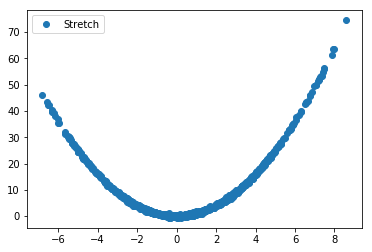

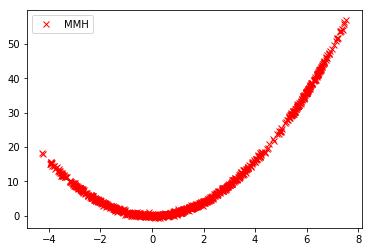

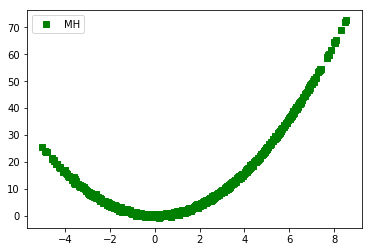

In [10]:
plt.plot(z.samples[:,0],z.samples[:,1],'o')
plt.legend(['Stretch'])
plt.show()
plt.plot(y.samples[:,0],y.samples[:,1],'rx')
plt.legend(['MMH'])
plt.show()
plt.plot(w.samples[:,0],w.samples[:,1],'gs')
plt.legend(['MH'])
plt.show()

A note on the distribution of samples:
    - For this distribution, the MH and MMH algorithms have very long correlation length (~100,000 samples, see Goodman and Weare, 2010). As a result, the affine invariant sampler with stretch moves produces a set of samples that is less correlated given a fixed jumping width of 1000 samples. 

## An additional example with a 2d Gaussian

Note that pdf_target, pdf_target_params must be lists of the same dimension as dimension.

In [11]:
x = MCMC(dimension=2, pdf_proposal_type='Normal', pdf_proposal_scale=[1., 1.], pdf_target_type='marginal_pdf',
         pdf_target=['normal', 'normal'], pdf_target_params=[[0, 1], [0, 1]], algorithm='MMH', 
         jump=10, nsamples=1000, seed=None)

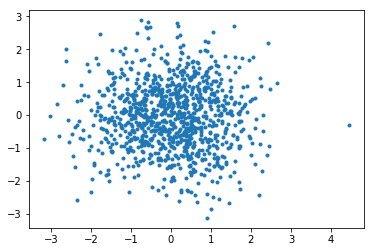

In [12]:
fig, ax = plt.subplots()
ax.plot(x.samples[:,0], x.samples[:,1], linestyle='none', marker='.')